In [1]:

# coding: utf-8

# In[14]:

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

class TwoPathConv(nn.Module):
    def __init__(self):
        super(TwoPathConv, self).__init__()
        self.local_conv1 = nn.Conv2d(4, 64, 7)
        #self.dp1 = nn.Dropout2d(.3)
        self.local_conv2 = nn.Conv2d(64, 64, 3)
        #self.dp2 = nn.Dropout2d(.3)
        self.local_conv3 = nn.Conv2d(4, 160, 13)
        #self.dp3 = nn.Dropout2d(.3)
        self.total_conv = nn.Conv2d(224, 5, 21)

    def forward(self, x):
        under_x = F.relu(self.local_conv3(x))
        x = self.local_conv1(x)
        #x = self.dp1(x)
        x = F.max_pool2d(F.relu(x), 4, stride = 1)
        x = self.local_conv2(x)
        #x = self.dp2(x)
        x = F.max_pool2d(F.relu(x), 2, stride = 1)
        x = torch.cat((x, under_x), 1)
        x = self.total_conv(x)
        x = x.view(-1,5)
        return x
    
import h5py
#challenge_f = h5py.File('Challenge.h5', 'r') #load challenge data
train_f = h5py.File('train.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
'''
train_f = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]
'''
#for i in enumerate(SAMPLE):
#    index, case = i
#    case1 = case[:2]
#    case2 = case[3:]
#    print(challenge_f[case1][case2].shape)
    
def create_test_batch(img = 0, x = 16, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (16,16), (16,16)), mode = 'constant')
    for y in range(16, Y + 16):
        batch.append(img1[:, x-16:x+17, y-16:y+17])
    batch = torch.from_numpy(np.array(batch))
    return batch

def create_test_batch_cas(img = 0, x = 32, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (32,32), (32,32)), mode = 'constant')
    for y in range(32, Y + 32):
        batch.append(img1[:, x-32:x+33, y-32:y+33])
    batch = torch.from_numpy(np.array(batch))
    return batch

# In[ ]:

In [2]:
import time
import numpy as np
from torch.autograd import Variable
net = TwoPathConv()
#net = LocalPathConv()
#net = InputCasNet()
net.load_state_dict(torch.load('two_path_cnn/p2_TPWconv_net1.txt'))
#net.load_state_dict(torch.load('local_path_cnn/phase2_param4.txt'))
#net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
net.cuda(1)

TwoPathConv (
  (local_conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
  (local_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (local_conv3): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
  (total_conv): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
)

In [28]:
prev_time = time.clock()
#print(matrix_pred)
s = 0
#matrix_pred = {}
pred = {}
matrix_pred ={}

for img in range(11, 12):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    matrix_pred[img] = []
    for x in range(16, X + 16):
    #for x in range(32, X + 32):
        pred[(img,x)] = []
        for z in range(Z):
            s += 1
            X_batch = create_test_batch(img = img, x = x, z = z)
            #X_batch = create_test_batch_cas(img = img, x = x, z = z)
            X_batch = Variable(X_batch.cuda(1))
            y_pred = net.forward(X_batch)
            y_pred = y_pred.data.cpu().numpy()
            if (s%100 == 0):
                print ('Ongoing ...' ,(img, x, z))
                print ('time used %.3f' % (time.clock()-prev_time))
            pred[(img,x)].append(y_pred.argmax(axis = 1)) 
        matrix_pred[img].append(pred[(img,x)])
array_img = np.array(matrix_pred[11]).transpose(1,2,0)
print(array_img.shape)

160 216 176
Ongoing ... (11, 16, 99)
time used 3.922
Ongoing ... (11, 17, 23)
time used 7.718
Ongoing ... (11, 17, 123)
time used 11.512
Ongoing ... (11, 18, 47)
time used 15.304
Ongoing ... (11, 18, 147)
time used 19.097
Ongoing ... (11, 19, 71)
time used 22.887
Ongoing ... (11, 19, 171)
time used 26.677
Ongoing ... (11, 20, 95)
time used 30.477
Ongoing ... (11, 21, 19)
time used 34.271
Ongoing ... (11, 21, 119)
time used 38.064
Ongoing ... (11, 22, 43)
time used 41.862
Ongoing ... (11, 22, 143)
time used 45.660
Ongoing ... (11, 23, 67)
time used 49.462
Ongoing ... (11, 23, 167)
time used 53.276
Ongoing ... (11, 24, 91)
time used 57.077
Ongoing ... (11, 25, 15)
time used 60.880
Ongoing ... (11, 25, 115)
time used 64.682
Ongoing ... (11, 26, 39)
time used 68.485
Ongoing ... (11, 26, 139)
time used 72.286
Ongoing ... (11, 27, 63)
time used 76.088
Ongoing ... (11, 27, 163)
time used 79.894
Ongoing ... (11, 28, 87)
time used 83.705
Ongoing ... (11, 29, 11)
time used 87.516
Ongoing ... (11

Ongoing ... (11, 123, 167)
time used 724.629
Ongoing ... (11, 124, 91)
time used 728.433
Ongoing ... (11, 125, 15)
time used 732.263
Ongoing ... (11, 125, 115)
time used 736.080
Ongoing ... (11, 126, 39)
time used 739.896
Ongoing ... (11, 126, 139)
time used 743.712
Ongoing ... (11, 127, 63)
time used 747.525
Ongoing ... (11, 127, 163)
time used 751.341
Ongoing ... (11, 128, 87)
time used 755.164
Ongoing ... (11, 129, 11)
time used 758.985
Ongoing ... (11, 129, 111)
time used 762.803
Ongoing ... (11, 130, 35)
time used 766.617
Ongoing ... (11, 130, 135)
time used 770.434
Ongoing ... (11, 131, 59)
time used 774.275
Ongoing ... (11, 131, 159)
time used 778.097
Ongoing ... (11, 132, 83)
time used 781.912
Ongoing ... (11, 133, 7)
time used 785.726
Ongoing ... (11, 133, 107)
time used 789.542
Ongoing ... (11, 134, 31)
time used 793.359
Ongoing ... (11, 134, 131)
time used 797.176
Ongoing ... (11, 135, 55)
time used 800.989
Ongoing ... (11, 135, 155)
time used 804.804
Ongoing ... (11, 136, 7

KeyError: 10

In [29]:
array_img = np.array(matrix_pred[11]).transpose(1,2,0)
print(array_img.shape)

(176, 216, 160)


In [31]:
import pickle as pkl
output1 = open('HG0002.pkl', 'wb')
pkl.dump(array_img, output1, protocol = 2)

(176, 216, 160)


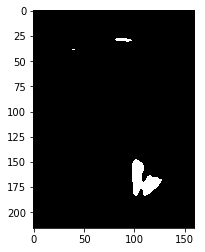

In [30]:
img = 11
matrix_pred[img] = np.array(matrix_pred[img])
print(array_img.shape)
#plt.imshow(matrix_pred[img][:,100,:], cmap='gray')
plt.imshow(array_img[100,:,:], cmap='gray')
plt.show()

In [ ]:
val_patch_size = 256
iteration = len(val_list) // val_patch_size
prev_time = time.clock()
correct = 0
for j in range(iteration):
    val_x, val_y = create_val_patch(val_patch_size, key = j)
    val_x, val_y = Variable(val_x.cuda(3)), val_y.cuda(3)
    #train
    #check accuracy
    val_pred = net.forward(val_x)
    val_pred = val_pred.view(-1, 5)
    _, predicted = torch.max(val_pred.data, 1)
    correct += (predicted == val_y).sum()
    total_test_size = val_patch_size * (j+1)
    if j % 10 == 0:
        print('iteration %d /%d:'%(j, iteration))
        print(float(j)/iteration,  'finished')
        print('Validation accuracy:', float(correct) / total_test_size)
        print('time used:%.3f'% (time.clock() - prev_time))

In [10]:
#cas-net test

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import torch.nn.init as ini
import multiprocessing
from multiprocessing import Queue
import random
from random import shuffle
import pickle

class InputCasNet(nn.Module):
    def __init__(self):
        super(InputCasNet, self).__init__()
        self.first_upper_layer1=nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.first_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.first_under_layer1=nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        
        self.first_final_layer=nn.Conv2d(224,5,21)
        
        self.second_upper_layer1=nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.second_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.second_under_layer1=self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        self.second_final_layer = nn.Conv2d(224,5,21)
    
    def forward(self, x1):
        upper_x=self.first_upper_layer2(self.first_upper_layer1(x1))
        under_x=self.first_under_layer1(x1)
        x=torch.cat((upper_x, under_x), 1)
        x=self.first_final_layer(x)
        x2=x1[:, :, 16:48+1, 16:48+1]*1.0
        x2=torch.cat((x, x2), 1)
        upper_x2=self.second_upper_layer2(self.second_upper_layer1(x2))
        under_x2=self.second_under_layer1(x2)
        x3=torch.cat((upper_x2, under_x2), 1)
        x3=self.second_final_layer(x3)
        return x3

cas_net=InputCasNet()
cas_net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
cas_net.cuda(0)

InputCasNet (
  (first_upper_layer1): Sequential (
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (first_upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (first_under_layer1): Sequential (
    (0): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
  )
  (first_final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  (second_upper_layer1): Sequential (
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1)